### Probabilistic Sharpe Ratio

$$\widehat{\mathrm{PSR}} \left[ \mathrm{SR}^*\right] = Z\left[ 
\frac{(\widehat{\mathrm{SR}} - \mathrm{SR}^*) \sqrt{T - 1}}
{\sqrt{
1 - \hat{\gamma}_3 \widehat{\mathrm{SR}} + \frac{\hat{\gamma}_4 - 1}{4} \widehat{\mathrm{SR}} ^ 2
}}
\right]$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, norm
from FinancialMachineLearning.backtest.backtest_statistics import *

np.random.seed(42)

#### Strategy 1

simulate a distribution of returns with negative skewness

In [2]:
mean_ret = 0.01
std_ret = 0.01
skew_ret = -0.5
alpha = skew_to_alpha(skew_ret)
dist_st1 = skewnorm(loc = mean_ret, scale = std_ret, a = alpha)

In [3]:
true_mean_st1 = dist_st1.stats('m')
true_std_st1  = np.sqrt(dist_st1.stats('v'))
true_skew_st1  = dist_st1.stats('s')
true_kurt_st1  = dist_st1.stats('k') + 3
print('Long term true weekly mean returns st1: {:.4f}'.format(true_mean_st1))
print('Long term true std returns st1: {:.4f}'.format(true_std_st1))
print('Long term true skew returns st1: {:.4f}'.format(true_skew_st1))
print('Long term true kurt returns st1: {:.4f}'.format(true_kurt_st1))

Long term true weekly mean returns st1: 0.0028
Long term true std returns st1: 0.0069
Long term true skew returns st1: -0.5000
Long term true kurt returns st1: 3.3471


Generates random **weekly returns** and check their moments statistic (in a large sample the skew should be equal to `skew_returns`, **the other moments are not guaranteed to acommplish our initial conditions**)

In [4]:
size = 52 # weekly

seed_st1 = 42
ret_st1 = dist_st1.rvs(size = size, random_state = seed_st1)
moments_st1 = moments(ret_st1)
print(moments_st1)

mean    0.002612
std     0.006459
skew   -0.316044
kurt    2.425439
dtype: float64


Calculate their estimated Sharpe Ratio($\hat{\mathrm{SR}}$). It is 'estimated' because it use the historical returns as a prediction of the future returns.

In [5]:
sr_st1 = estimated_sharpe_ratio(ret_st1)
print(f"Sharpe Ratio of strategy 1 dist. : {sr_st1 : .4f}")

Sharpe Ratio of strategy 1 dist. :  0.4045


In [6]:
ann_sr_st1 = ann_estimated_sharpe_ratio(ret_st1, periods = 52)
print(f"Annual Sharpe Ratio of strategy 1 dist. : {ann_sr_st1 : .4f}")

Annual Sharpe Ratio of strategy 1 dist. :  2.9166


#### Strategy 2

Simulate a normal distribution od returns with better mean and same std as the strategy 1

In [7]:
extra_edge = 0.0012
dist_st2 = norm(loc = true_mean_st1 + extra_edge, scale = true_std_st1)

In [8]:
true_mean_st2 = dist_st2.stats('m')
true_std_st2  = np.sqrt(dist_st2.stats('v'))
true_skew_st2  = dist_st2.stats('s')
true_kurt_st2  = dist_st2.stats('k') + 3
print('Long term true weekly mean returns st2: {:.4f}'.format(true_mean_st2))
print('Long term true std returns st2: {:.4f}'.format(true_std_st2))
print('Long term true skew returns st2: {:.2f}'.format(true_skew_st2))
print('Long term true kurt returns st2: {:.2f}'.format(true_kurt_st2))

Long term true weekly mean returns st2: 0.0040
Long term true std returns st2: 0.0069
Long term true skew returns st2: 0.00
Long term true kurt returns st2: 3.00


Generates random **weekly returns** and check their moments statistic (in a large sample the mean and std should be equal to the `moments_st1`, and the skew should be 0 and kurtosis 3)

In [9]:
seed_st2 = 42
ret_st2 = dist_st2.rvs(size = size, random_state = seed_st2)

moments_st2 = moments(ret_st2)
print(moments_st2)

mean    0.002450
std     0.006329
skew    0.116464
kurt    2.607143
dtype: float64


In [10]:
sr_st2 = estimated_sharpe_ratio(ret_st2)
print(f"Sharpe Ratio of strategy 2 dist. : {sr_st2 : .4f}")

Sharpe Ratio of strategy 2 dist. :  0.3871


In [11]:
ann_sr_st2 = ann_estimated_sharpe_ratio(ret_st2)
print(f"Annual Sharpe Ratio of strategy 2 dist. : {ann_sr_st2 : .4f}")

Annual Sharpe Ratio of strategy 2 dist. :  6.2538


#### Probabilistic Sharpe Ratio (PSR)

```
def probabalistic_sharpe_ratio(
    observed_sr: float, 
    benchmark_sr: float,
    number_of_returns: int, 
    skewness_of_returns: float = 0,
    kurtosis_of_returns: float = 3
) -> float
```

In [12]:
sharpe_bench = 0

In [13]:
psr_st1 = probabilistic_sharpe_ratio(
    observed_sr = sr_st1,
    benchmark_sr = sharpe_bench,
    number_of_returns = len(ret_st1),
    skewness_of_returns = true_skew_st1,
    kurtosis_of_returns = true_kurt_st1
)
print(f"Probabilistic Sharpe Ratio of strategy 1 : {psr_st1 : .4f}")

Probabilistic Sharpe Ratio of strategy 1 :  0.9944


In [14]:
psr_st2 = probabilistic_sharpe_ratio(
    observed_sr = sr_st2,
    benchmark_sr = sharpe_bench,
    number_of_returns = len(ret_st2),
    skewness_of_returns = true_skew_st2,
    kurtosis_of_returns = true_kurt_st2
)
print(f"Probabilistic Sharpe Ratio of strategy 2 : {psr_st2 : .4f}")

Probabilistic Sharpe Ratio of strategy 2 :  0.9962


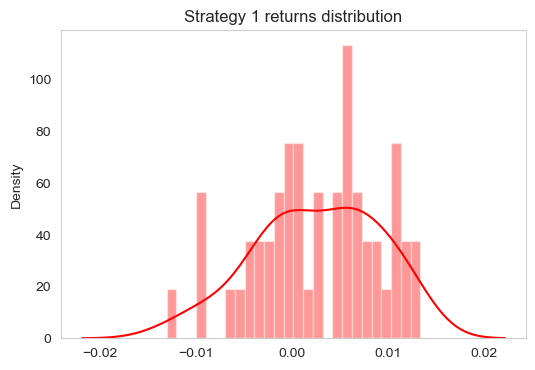

In [15]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (6, 4))
sns.distplot(
    pd.Series(ret_st1), 
    hist = True, 
    kde = True, 
    color = 'red',
    bins = size // 2
).set_title('Strategy 1 returns distribution')
plt.grid(False)
plt.show()

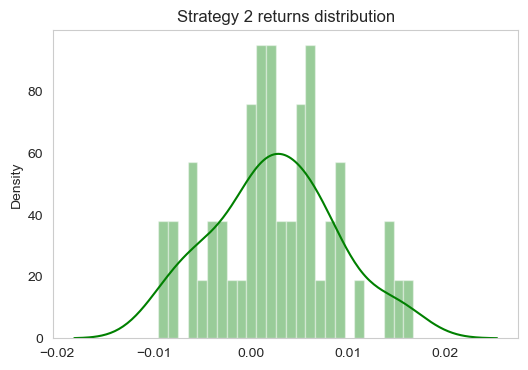

In [16]:
plt.figure(figsize = (6, 4))
sns.distplot(
    pd.Series(ret_st2), 
    hist = True, 
    kde = True, 
    color = 'green',
    bins = size // 2
).set_title('Strategy 2 returns distribution')
plt.grid(False)
plt.show()

In [17]:
estimated_sr_std_st1 = estimated_sharpe_ratio_stdev(ret_st1)
estimated_sr_std_st2 = estimated_sharpe_ratio_stdev(ret_st2)

print(f'The estimated Sharpe Ratio of strategy 1 have a stdDev of: {estimated_sr_std_st1 : .4f}')
print(f'The estimated Sharpe Ratio of strategy 2 have a stdDev of: {estimated_sr_std_st2 : .4f}')

The estimated Sharpe Ratio of strategy 1 have a stdDev of:  0.1525
The estimated Sharpe Ratio of strategy 2 have a stdDev of:  0.1411


#### Out of sample

In [18]:
oos_size = 10000000

oos_ret_st1 = dist_st1.rvs(size = oos_size)
true_moments_st1 = moments(oos_ret_st1)
print(true_moments_st1)

mean    0.002750
std     0.006888
skew   -0.498687
kurt    3.342231
dtype: float64


In [19]:
ann_true_sr_st1 = ann_estimated_sharpe_ratio(oos_ret_st1, periods = 52)
print(f"Annual true sharpe ratio of strategy 1 : {ann_true_sr_st1 : .3f}")

Annual true sharpe ratio of strategy 1 :  2.879


In [20]:
oos_ret_st2 = dist_st2.rvs(size = oos_size)
true_moments_st2 = moments(oos_ret_st2)
print(true_moments_st2)

mean    0.003949
std     0.006893
skew    0.000797
kurt    2.999979
dtype: float64


In [21]:
ann_true_sr_st2 = ann_estimated_sharpe_ratio(oos_ret_st2, periods = 52)
print(f"Annual true sharpe ratio of strategy 2 : {ann_true_sr_st2 : .3f}")

Annual true sharpe ratio of strategy 2 :  4.132


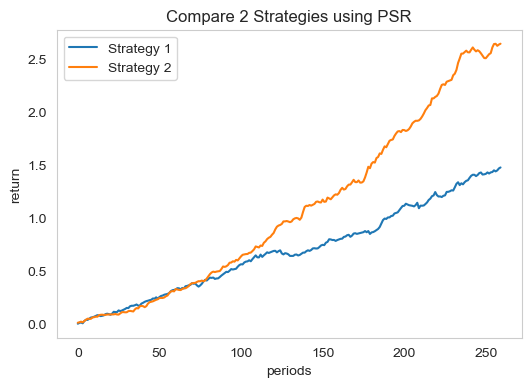

In [22]:
pd.DataFrame(
    {'Strategy 1': pd.Series(oos_ret_st1).add(1).cumprod().sub(1).iloc[:52*5],
     'Strategy 2': pd.Series(oos_ret_st2).add(1).cumprod().sub(1).iloc[:52*5]}
).plot(
    figsize = (6, 4),
    grid = False,
    title = "Compare 2 Strategies using PSR"
)
plt.xlabel("periods")
plt.ylabel("return")
plt.show()

<Axes: title={'center': 'Distribution of 2 strategies'}, ylabel='Density'>

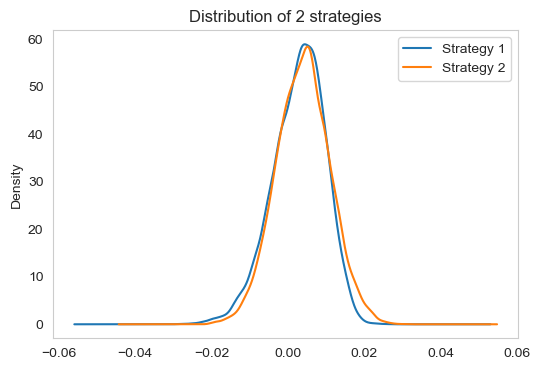

In [23]:
pd.DataFrame(
    {'Strategy 1': pd.Series(oos_ret_st1).iloc[:10000],
     'Strategy 2': pd.Series(oos_ret_st2).iloc[:10000]}
).plot.density(
    grid = False,
    figsize = (6,4),
    title = "Distribution of 2 strategies"
)

In [83]:
skew = np.linspace(-0.9999, 0.9999, 100)
observed = np.arange(1, 13.5, 0.125)

In [90]:
matrix = np.zeros(10000).reshape(100, 100)
for i in range(len(skew)) :
    for j in range(len(observed)) : 
        psr = probabilistic_sharpe_ratio(
            observed_sr = 1.5,
            benchmark_sr = 1.0,
            number_of_returns = observed[j],
            skewness_of_returns = skew[i],
            kurtosis_of_returns = 3.0
        )
        matrix[j][i] = psr

matrix = pd.DataFrame(matrix, columns = skew, index = observed)
matrix = matrix.sort_index(ascending = False)

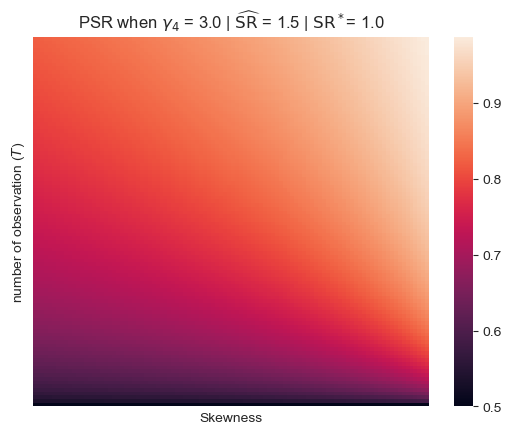

In [91]:
sns.heatmap(matrix)
plt.xlabel('Skewness')
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel(r'number of observation ($T$)')
plt.title(r"PSR when $\gamma_4$ = 3.0 | $\widehat{\mathrm{SR}}$ = 1.5 | $\mathrm{SR}^*$= 1.0")
plt.show()

In [92]:
matrix = np.zeros(10000).reshape(100, 100)
for i in range(len(skew)) :
    for j in range(len(observed)) : 
        psr = probabilistic_sharpe_ratio(
            observed_sr = 1.0,
            benchmark_sr = 1.0,
            number_of_returns = observed[j],
            skewness_of_returns = skew[i],
            kurtosis_of_returns = 3.0
        )
        matrix[j][i] = psr

matrix = pd.DataFrame(matrix, columns = skew, index = observed)
matrix = matrix.sort_index(ascending = False)

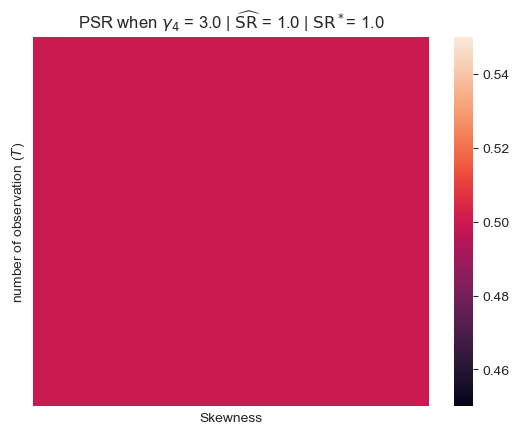

In [93]:
sns.heatmap(matrix)
plt.xlabel('Skewness')
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel(r'number of observation ($T$)')
plt.title(r"PSR when $\gamma_4$ = 3.0 | $\widehat{\mathrm{SR}}$ = 1.0 | $\mathrm{SR}^*$= 1.0")
plt.show()

In [94]:
matrix = np.zeros(10000).reshape(100, 100)
for i in range(len(skew)) :
    for j in range(len(observed)) : 
        psr = probabilistic_sharpe_ratio(
            observed_sr = 0.75,
            benchmark_sr = 1.0,
            number_of_returns = observed[j],
            skewness_of_returns = skew[i],
            kurtosis_of_returns = 3.0
        )
        matrix[j][i] = psr

matrix = pd.DataFrame(matrix, columns = skew, index = observed)
matrix = matrix.sort_index(ascending = False)

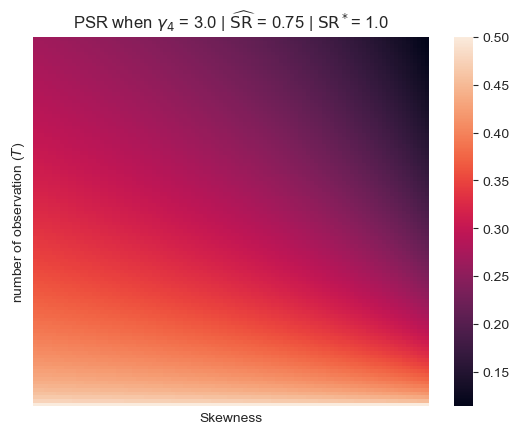

In [95]:
sns.heatmap(matrix)
plt.xlabel('Skewness')
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel(r'number of observation ($T$)')
plt.title(r"PSR when $\gamma_4$ = 3.0 | $\widehat{\mathrm{SR}}$ = 0.75 | $\mathrm{SR}^*$= 1.0")
plt.show()